In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import tifffile

In [2]:
import pre_process_mm as pre
import mm3_adapted_cell_segmentation as mm3seg
import mm3_adapted_cell_tracking as mm3track

# Correct for image drift and rotation

In [3]:
folder_name = 'DUMM_giTG66_Glucose_012325'

In [3]:
# Specify experiment folder with aquired positions, default output from Covert lab scope's micromanager
root_dir = f'/Users/noravivancogonzalez/Desktop/{folder_name}'
# Privide experiment suffix
# Indicate phase channel index
drift_corrected_path = pre.drift_correct(root_dir, 'DuMM', c=0)

Applying drift: 100%|█████████████████████████| 180/180 [00:10<00:00, 17.24it/s]


In [4]:
drift_corrected_path = f'/Users/noravivancogonzalez/Desktop/{folder_name}/hyperstacked/drift_corrected'

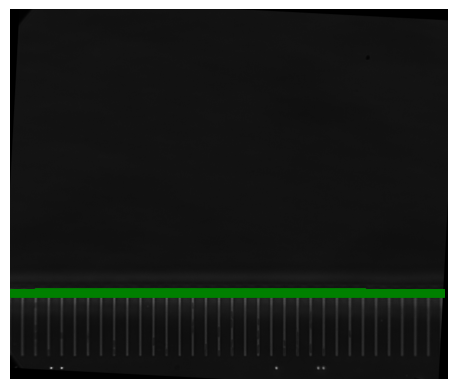

Rotation angle:
-3.010146479971967


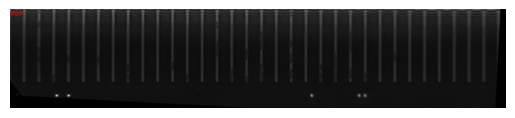

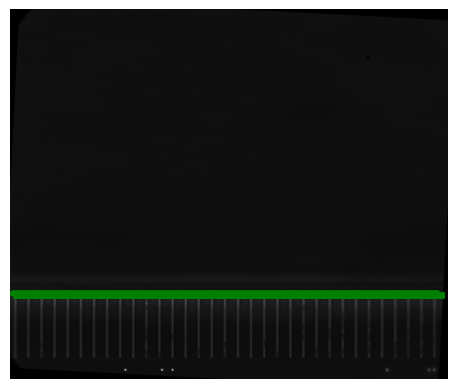

Rotation angle:
-2.9860101737247455


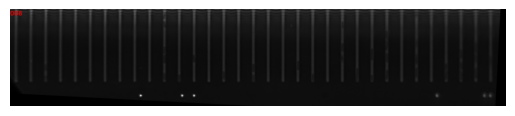

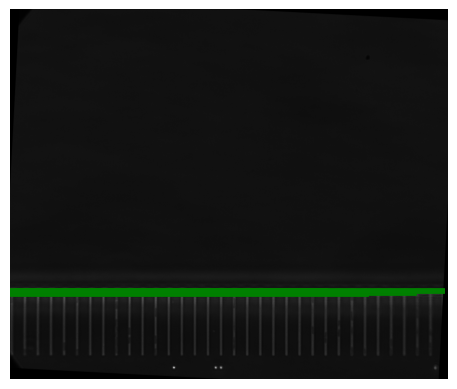

Rotation angle:
-2.9941131757559636


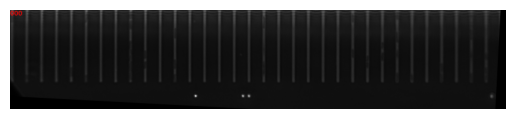

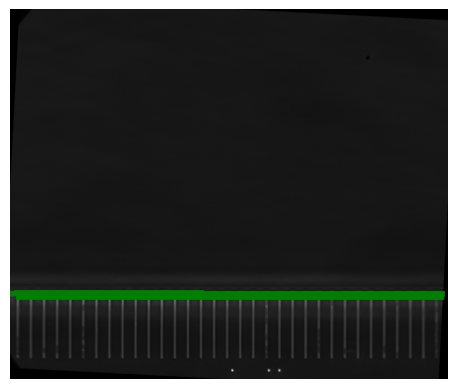

Rotation angle:
-2.9898406533068664


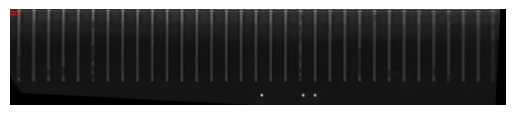

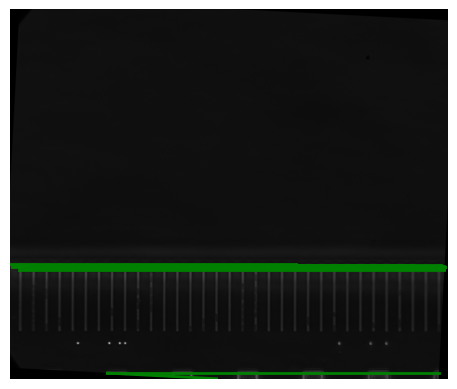

[[189 707 835 707]]
[[189 708 402 719]]
Rotation angle:
-3.0071159066856183


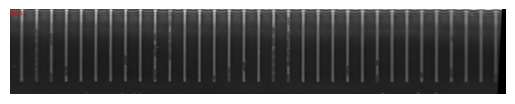

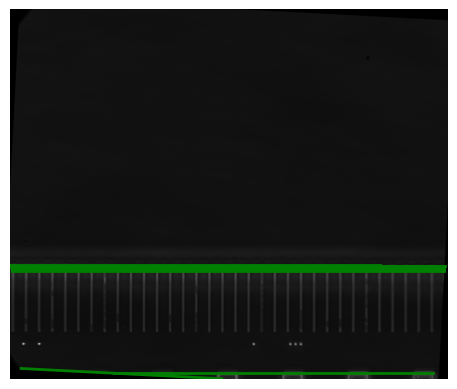

[[ 21 699 412 719]]
[[203 708 823 708]]
Rotation angle:
-2.9883513453788257


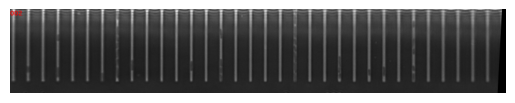

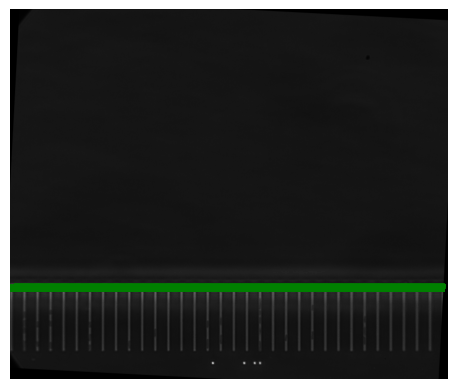

Rotation angle:
-3.001233380295909


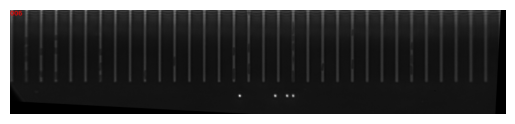

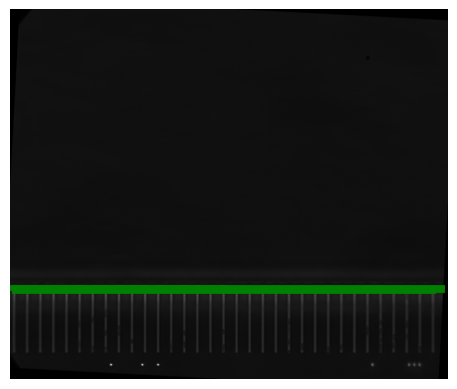

Rotation angle:
-3.0143500281162603


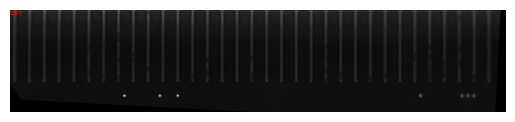

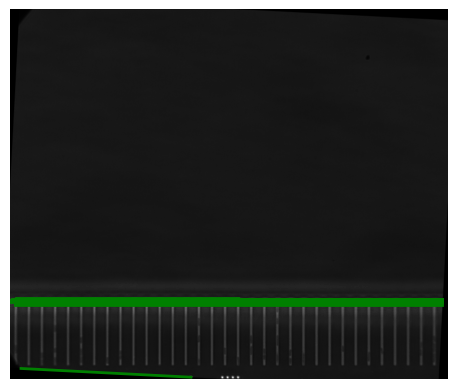

[[ 21 699 352 716]]
Rotation angle:
-2.9819198093623562


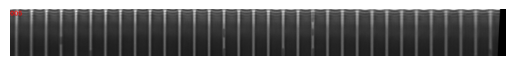

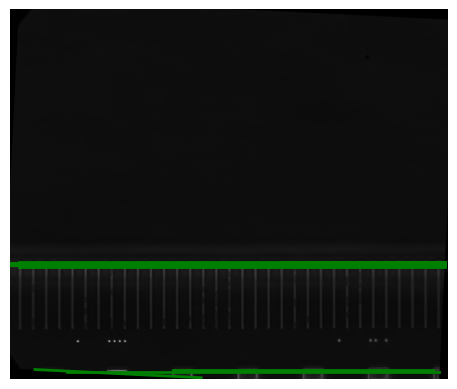

[[ 48 701 372 717]]
[[111 705 836 705]]
[[318 702 824 702]]
Rotation angle:
-2.793600702382824


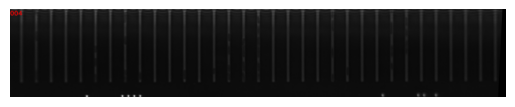

Successfully rotated stack


In [5]:
# Growth channel length depends on # of pixels, measure on image for proper estimation
path_to_rotated_images = pre.rotate_stack(drift_corrected_path, c=0, growth_channel_length=400)

# Isolate microfluidic channels

channels identified in FOV 009
saving sliced microfluidic channels as tcyx stacks
channels identified in FOV 008
saving sliced microfluidic channels as tcyx stacks
channels identified in FOV 003
saving sliced microfluidic channels as tcyx stacks
channels identified in FOV 002
saving sliced microfluidic channels as tcyx stacks
channels identified in FOV 000
saving sliced microfluidic channels as tcyx stacks
channels identified in FOV 001
saving sliced microfluidic channels as tcyx stacks
channels identified in FOV 005
saving sliced microfluidic channels as tcyx stacks
channels identified in FOV 004
saving sliced microfluidic channels as tcyx stacks
channels identified in FOV 006
saving sliced microfluidic channels as tcyx stacks
channels identified in FOV 007
saving sliced microfluidic channels as tcyx stacks


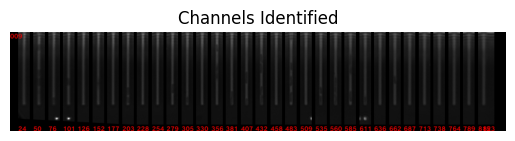

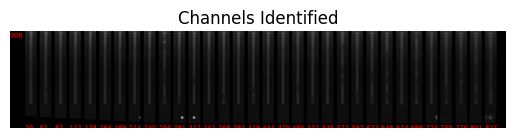

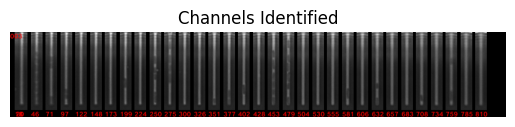

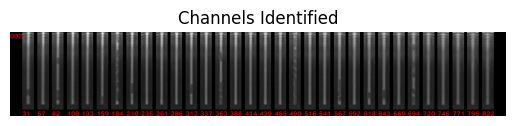

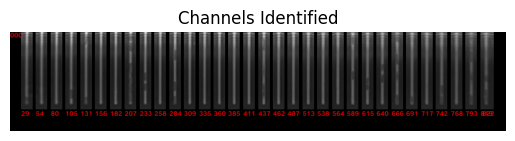

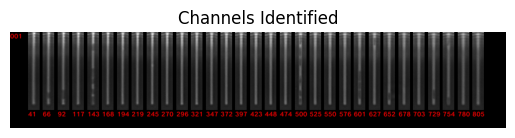

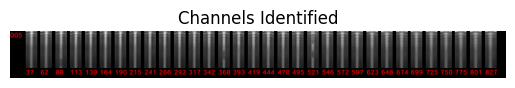

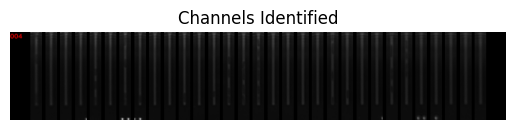

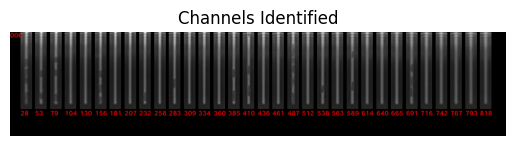

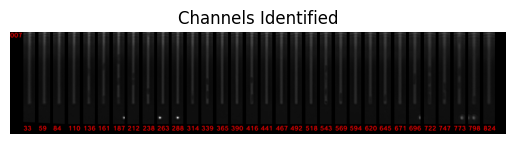

In [6]:
# Separate mother machine channels as individual files
path_to_mm_channels = pre.extract_mm_channels(path_to_rotated_images)

In [12]:
# There are IDs added to each microfluidic channel identified in the image. 
#These images can be found in the mm_channels subfulder and are labeled
# for example as "FOV001_mm_channel_mask.tif"

# Subtract background from phase and fluorescent images

In [7]:
# Continue analysis on specific field of view
FOV = '003'

In [8]:
# Specify the ID numebr of an empty channel to subtract background from phase image
empty_stack_id = '326'

In [9]:
# Specify ID numbers for channels with cells
ana_peak_ids = ['453', '479', '275','250']

In [10]:
# Indicate what kind of channel to subtract from in method, set to 'phase' or 'fluor' for a fluorescent channel
# Indicate the index of the channel to which subtraction will occur
pre.subtract_fov_stack(path_to_mm_channels, FOV, empty_stack_id, ana_peak_ids, method = 'phase', channel_index= 0)

In [11]:
# Subtract background from fluorescent channel
pre.subtract_fov_stack(path_to_mm_channels, FOV, empty_stack_id, ana_peak_ids, method = 'fluor', channel_index= 1)

# Identify cells in image per microfluidic channel

In [39]:
fov_id = '003'
peak_id = '275' #'453' #'479' #'275' #'250'
phase_channel = '0'
fluor_channel = '1'
path_to_phase_stack = f'/Users/noravivancogonzalez/Desktop/{folder_name}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/subtracted_FOV_{fov_id}_region_{peak_id}_c_{phase_channel}.tif'
path_to_fluor_stack = f'/Users/noravivancogonzalez/Desktop/{folder_name}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/subtracted_FOV_{fov_id}_region_{peak_id}_c_{fluor_channel}.tif'

In [40]:
# Specify a mask output path where labeled masks can be added to further process images with cellTK
output_path = f'/Users/noravivancogonzalez/Desktop/{folder_name}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/outputs'

In [101]:
# This function produces a labeled mask for every time point, which can be used to identify cells
# The parameters for this function are based on # of pixels and whether there is pixel binning
# A section included at the bottom of this notebook indicates how to find the best parameters
mm3seg.segment_chnl_stack(path_to_phase_stack,
						   output_path,
						   OTSU_threshold=1.5,
						   first_opening=1,
						   distance_threshold=1,
						   second_opening_size=1,
						   min_object_size=2) 

In [102]:
labeled_stack = f'/Users/noravivancogonzalez/Desktop/{folder_name}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/mm3_segmented_subtracted_FOV_{fov_id}_region_{peak_id}_c_{phase_channel}.tif'

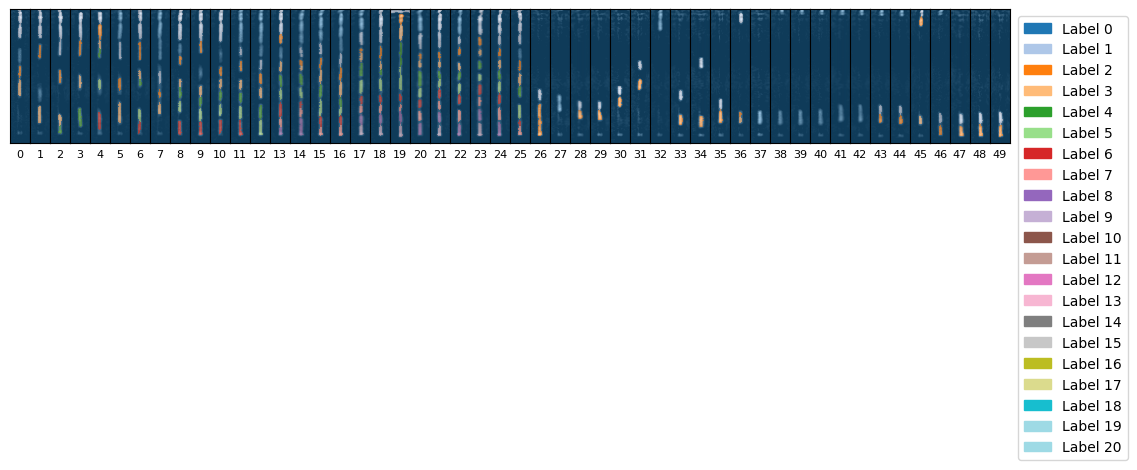

In [103]:
# Plot identified cells in from start timeframe, until timeframe 20 to get a sense of the success of cell segementation
# In this case only some of the segmentation looks of, a lot of cells are stacked at an angle with overlaps, making it difficult for the
# algorithm to distinguish one cell from another.
mm3seg.display_segmentation(path_to_phase_stack, mask_path = labeled_stack, start=0, end=50, alpha=0.5)

In [104]:
# Extract information from identified cells in a dictionary
# This function attempts to identify cells across timeframes, tracking divisions.
# Time between frames can be specified in minutes to create a timeline
# Pixel to micron conversion can also be specified here to determine cell area in microns, otherwise it is reported in pixels
cells_dict = mm3track.make_lineage_chnl_stack(path_to_stack = path_to_phase_stack, 
                                              labeled_stack = labeled_stack, 
                                              fov_id = int(fov_id), 
                                              peak_id = int(peak_id), 
                                              time_btwn_frames =5, pxl2um = 1)

In [105]:
# Extract information on cell fluorescence intensity
mm3track.find_cell_intensities(path_to_fluor_stack, labeled_stack, cells_dict, midline=False)

In [106]:
# Report information from cell dictionary in a pandas datframe
cells_pd = mm3track.cells2df(cells_dict, num_time_frames = 5)

In [107]:
cells_pd.head(3)

,cell_id,fov,peak,birth_label,parent,daughters,birth_time_index,time_index,labels,areas_(pxls^2),lengths_(pxls),widths_(pxls),orientations,centroids,generation time_(min),fl_area_avgs,bb_xLeft,bb_yTop,bb_width,bb_height
9,f03p0275t0006r05,3,275,5,f03p0275t0003r04,None,6,6,5,34.0,12.041595,2.0,-1.511691,"(105.55882352941177, 9.058823529411764)",None,412.941176,100,8,113,11
9,f03p0275t0006r05,3,275,5,f03p0275t0003r04,None,6,9,5,33.0,12.0,2.0,1.568542,"(105.3030303030303, 9.878787878787879)",None,310.212121,99,9,112,12
9,f03p0275t0006r05,3,275,5,f03p0275t0003r04,None,6,10,5,29.0,11.0,2.0,-1.561195,"(100.89655172413794, 9.827586206896552)",None,309.827586,95,9,107,12


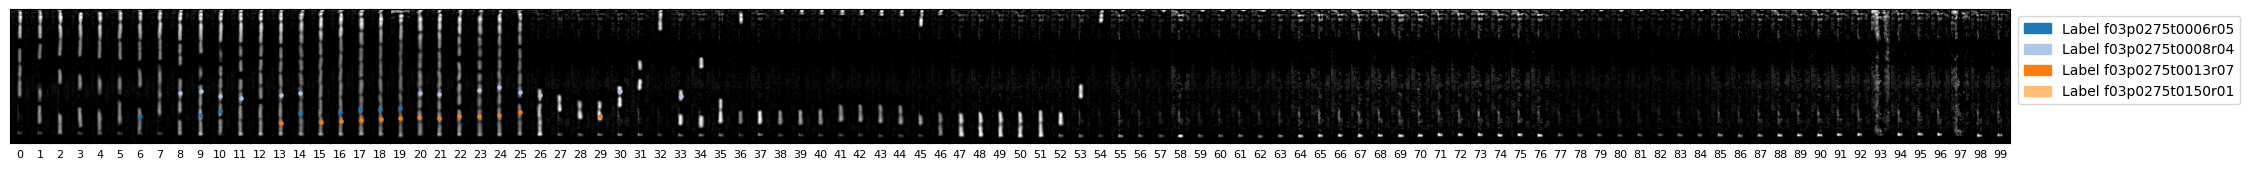

In [108]:
# If mask is not specified but there is cell information in a pandas dataframe, identified centroids can be superimposed on phase image
mm3seg.display_segmentation(path_to_phase_stack, mask_path = None, alpha = 0.5, cells_df = cells_pd, start=0, end=100)

# Analysis of identified cells

In [109]:
def cell_color_dict(cells_df):
    color_dict = {}
    unique_cell_ids = cells_df['cell_id'].unique()
    total_number_labels = len(unique_cell_ids)
    number_of_colors_needed = max(20, total_number_labels)
    # Get a colormap with  distinct colors, for potential cell labels
    cmap = plt.cm.get_cmap('tab20', number_of_colors_needed)
    # Create a dictionary mapping integers to hex color codes
    for color_i, cell_id in enumerate(unique_cell_ids):
        color = cmap(color_i)[:3]  # Extract RGB values
        color_dict[cell_id] = color
    return color_dict

In [110]:
color_dict = cell_color_dict(cells_pd)

/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_91832/419849173.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', number_of_colors_needed)


Text(0.5, 28.999999999999986, 'Time frames')

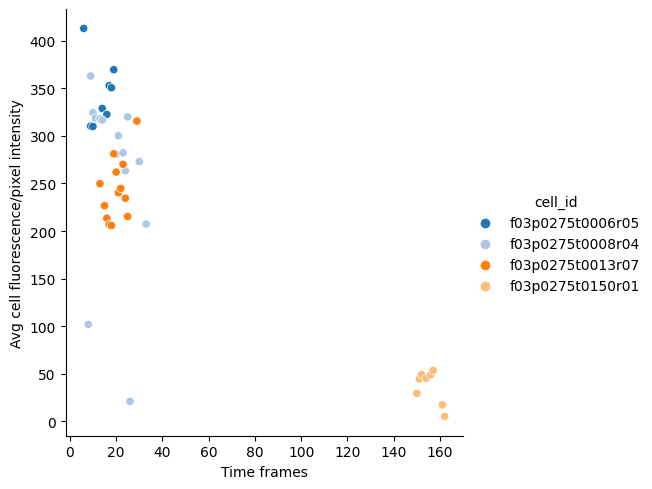

In [111]:
sns.relplot(data=cells_pd, x= 'time_index', y= 'fl_area_avgs', hue= 'cell_id', palette = color_dict)

sns.despine()

plt.ylabel('Avg cell fluorescence/pixel intensity')
plt.xlabel('Time frames')

Text(0.5, 28.999999999999986, 'Time frames')

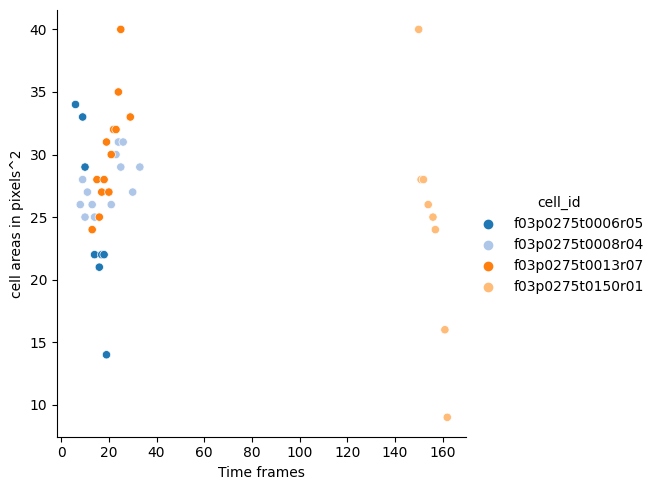

In [112]:
sns.relplot(data=cells_pd, x= 'time_index', y= 'areas_(pxls^2)', hue= 'cell_id', palette = color_dict)

sns.despine()

plt.ylabel('cell areas in pixels^2')
plt.xlabel('Time frames')

In [113]:
cells_pd['cell_id'].unique()

array(['f03p0275t0006r05', 'f03p0275t0008r04', 'f03p0275t0013r07',
       'f03p0275t0150r01'], dtype=object)

In [33]:
# based on the fluoresence intensity plot above we can see that cell 'f01p1164t0054r06' may be demonstrating higher fluorescence expression
# And that is only tracked aroynd timeframes 50-80

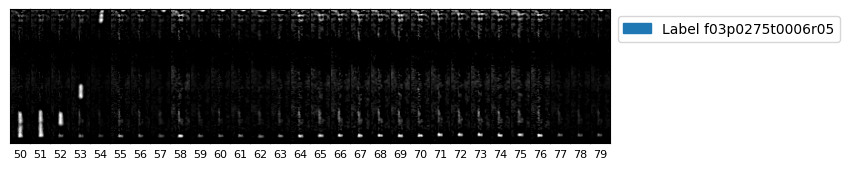

In [114]:
# Track cell 'f01p1164t0054r06'in phase channel
cell_df = cells_pd[cells_pd['cell_id'].isin(['f03p0275t0006r05'])] 
mm3seg.display_segmentation(path_to_phase_stack, mask_path = None, alpha = 0.5, cells_df = cell_df, start=50, end=80)

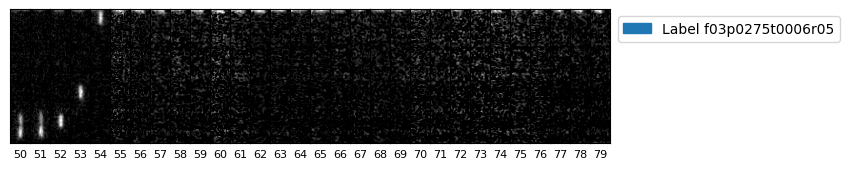

In [115]:
# Track cell 'f03p0275t0006r05'in fluorescent channel
mm3seg.display_segmentation(path_to_fluor_stack, mask_path = None, alpha = 0.5, cells_df = cell_df, start=50, end=80)

# Determine parameters for mm3seg.segment_chnl_stack

In [18]:
fov_id = '003'
peak_id = '453' #, '479', '275','250'
phase_channel = '0'
fluor_channel = '1'
path_to_phase_stack = f'/Users/noravivancogonzalez/Desktop/{folder_name}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/subtracted_FOV_{fov_id}_region_{peak_id}_c_{phase_channel}.tif'

In [25]:
image_stack = tifffile.imread(path_to_phase_stack)
image = image_stack[0]

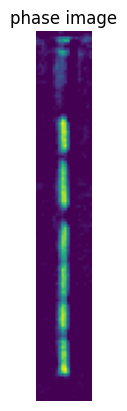

In [26]:
plt.figure()
plt.imshow(image)
plt.title('phase image')
plt.axis('off')  # Hide axis labels
plt.draw()

In [27]:
from skimage.filters import threshold_otsu

In [55]:
import skimage.segmentation as segmentation

In [31]:
from skimage import morphology

In [47]:
import scipy.ndimage as ndi

In [ ]:
OTSU_threshold=1
first_opening = 1
distance_threshold=1
second_opening_size=1
min_object_size=1

In [64]:
thresh = threshold_otsu(image)  # finds optimal OTSU threshhold value
threshholded = image > OTSU_threshold * thresh  # will create binary image

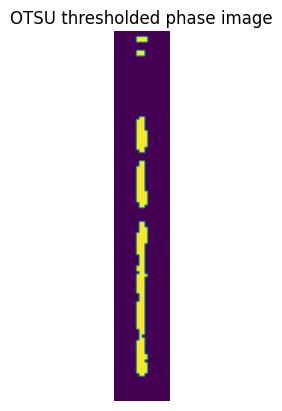

In [65]:
plt.figure()
plt.imshow(threshholded)
plt.title('OTSU thresholded phase image')
plt.axis('off')  # Hide axis labels
plt.draw()

In [66]:
# Opening = erosion then dialation.
# opening smooths images, breaks isthmuses, and eliminates protrusions.
# "opens" dark gaps between bright features.
# Create a diagonal line-shaped footprint
diagonal_footprint = np.zeros((3, 3))
np.fill_diagonal(diagonal_footprint, 1)

morph = morphology.binary_opening(threshholded, diagonal_footprint)

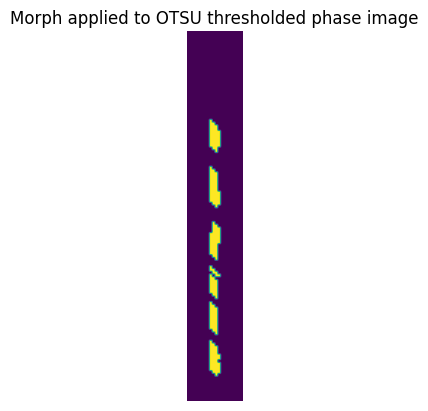

In [67]:
plt.figure()
plt.imshow(morph)
plt.title('Morph applied to OTSU thresholded phase image')
plt.axis('off')  # Hide axis labels
plt.draw()

In [74]:
distance_threshold = 1
distance = ndi.distance_transform_edt(morph)
# threshold distance image
distance_thresh = np.zeros_like(distance)
distance_thresh[distance < distance_threshold] = 0
distance_thresh[distance >= distance_threshold] = 1

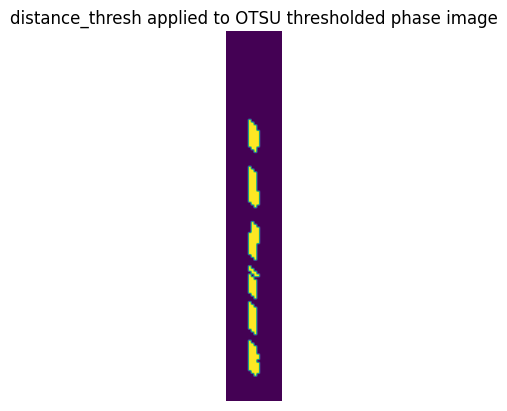

In [75]:
plt.figure()
plt.imshow(distance_thresh)
plt.title('distance_thresh applied to OTSU thresholded phase image')
plt.axis('off')  # Hide axis labels
plt.draw()

In [76]:
distance_opened = morphology.binary_opening(
        distance_thresh, morphology.disk(1)
)

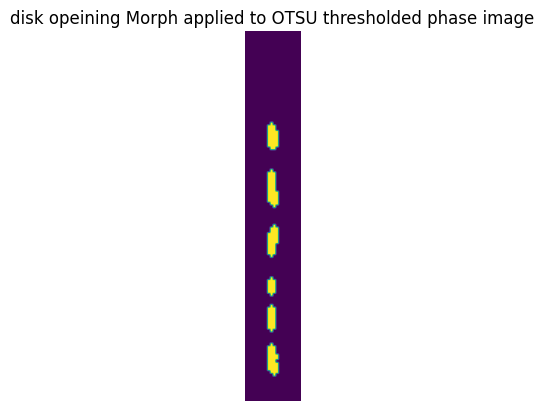

In [77]:
plt.figure()
plt.imshow(distance_opened)
plt.title('disk opeining Morph applied to OTSU thresholded phase image')
plt.axis('off')  # Hide axis labels
plt.draw()

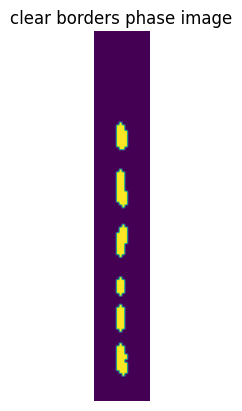

In [78]:
# remove artifacts connected to image border
cleared = segmentation.clear_border(distance_opened)
plt.figure()
plt.imshow(cleared)
plt.title('clear borders phase image')
plt.axis('off')  # Hide axis labels
plt.draw()

In [79]:
labeled, label_num = morphology.label(cleared, connectivity=1, return_num=True)
if label_num > 1:
    labeled = morphology.remove_small_objects(labeled, min_size=2)

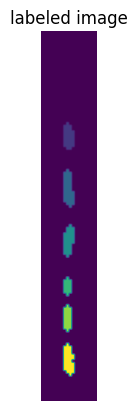

In [80]:
plt.figure()
plt.imshow(labeled)
plt.title('labeled image')
plt.axis('off')  # Hide axis labels
plt.draw()

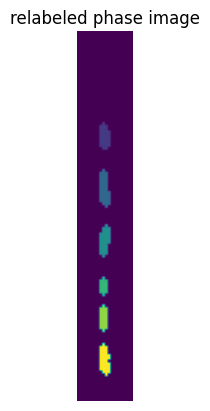

In [81]:
# relabel now that small objects and labels on edges have been cleared
markers = morphology.label(labeled, connectivity=2)
plt.figure()
plt.imshow(markers)
plt.title('relabeled phase image')
plt.axis('off')  # Hide axis labels
plt.draw()

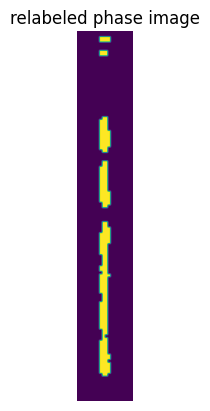

In [82]:
# the binary image for the watershed, which uses the unmodified OTSU threshold
threshholded_watershed = threshholded
plt.figure()
plt.imshow(threshholded_watershed)
plt.title('relabeled phase image')
plt.axis('off')  # Hide axis labels
plt.draw()

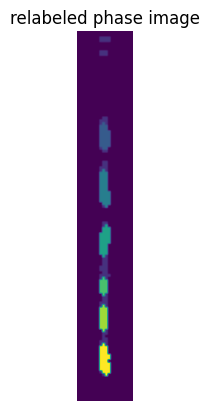

In [83]:
# set anything outside of OTSU threshold to -1 so it will not be labeled
markers[threshholded_watershed == 0] = -1
# here is the main algorithm
plt.figure()
plt.imshow(markers)
plt.title('relabeled phase image')
plt.axis('off')  # Hide axis labels
plt.draw()

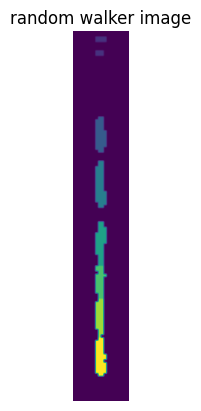

In [84]:
labeled_image = segmentation.random_walker(-1 * image, markers)
plt.figure()
plt.imshow(labeled_image)
plt.title('random walker image')
plt.axis('off')  # Hide axis labels
plt.draw()

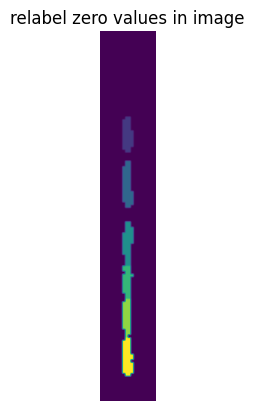

In [85]:
# put negative values back to zero for proper image
labeled_image[labeled_image == -1] = 0
plt.figure()
plt.imshow(labeled_image)
plt.title('relabel zero values in image')
plt.axis('off')  # Hide axis labels
plt.draw()